In [1]:
import matplotlib.pyplot as plt
import numpy as np

# An Introduction to Fitting Rotation Maps

A common task for analyses of protoplanetary disks is to infer their geometrical properties, namely the source centre, $(x_0,\, y_0)$, the inclination $i$, position angle, ${\rm PA}$, and stellar (dynamical) mass, $M_{\rm star}$, by fitting a simple Keplerian rotation pattern to a measured rotation pattern. In this notebook we'll look at how to use `eddy` to fit rotation maps, provide some constraints on these model parameters and search for structure in the residuals.

## TW Hya - A Geometrically Thin Case

### 1. Getting the Data

In this tutorial, we'll use $^{12}{\rm CO} \,\, (2-1)$ observations of TW Hya, described in [Huang et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...852..122H), and is available for download [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC).

### 2. Making a Rotation Map

The first thing we need is a rotation map, i.e. a map of the line-of-sight velocity for each pixel. There's a few different ways to make this from your data, for example a traditional intensity-weighted average velocity (first moment map), which is what CASA produces with its [immoments](https://casa.nrao.edu/casadocs/casa-5.1.0/global-task-list/task_immoments/about) command, or 'quadratic' method, as advocated for in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T). Each of these methods have their benefits, and you should consider which is the most appropriate statistic for the scienece you want to do.

As we are performing model fitting, we also want some idea of the uncertainties on the line-of-sight velocities. Unfortunately, CASA does not calculate these for you, but [bettermoments](https://github.com/richteague/bettermoments) does, following the uncertainties described in [Teague (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...74T/abstract). These aren't essential for use with `eddy` as you are able to assume the uncertainties are some fraction of the line-of-sight velocity - not ideal, but it usually works.

If you do not want to make your own line-of-sight velocity maps, you can download ones already made with `bettermoments` through the [eddy Dataverse](https://dataverse.harvard.edu/dataverse/eddy). This will contain the line-of-sight velocity map, `TWHya_CO_cube_v0.fits` and the associated uncertainty, `TWHya_CO_cube_dv0.fits`.

### 3. Loading up the Data

Within `eddy` we have defined a `rotationmap` class which provides all the functionality we'll need. Let's load it up.

In [2]:
from eddy import rotationmap

When loading the data we need _at least_ the rotation map. If you have a map of the uncertainties for each pixel, they can be included with the `uncertainty` argument. If you don't, that's OK as it was assume a 10% uncertainty on each pixel by default. The uncertainty can be changed on the fly through the `cube.error` parameter.

We have also downsampled the data so that we only included (roughly) spatially independent pixel. Additionally you can enter any integer to downsample by that factor. This is optional but useful for speeding up things when you're playing around.

Using the `FOV` argument we have also clipped the cube down to the region of interest. Note that when `eddy` is making a rotation map, it makes it __for the full image__, even if you're only fitting an inner region. Clipping down to the region of interest will considerably speed up the process.

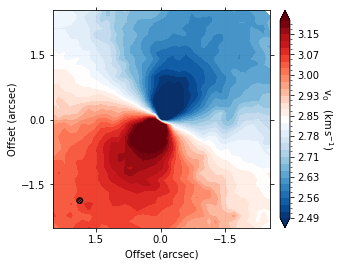

In [3]:
# Load up the data.

cube = rotationmap(path='../../cubes/TWHya_CO_cube_v0.fits',
                   uncertainty='../../cubes/TWHya_CO_cube_dv0.fits',
                   downsample='beam',
                   FOV=5.0)

# Inspect the data.

cube.plot_data()

In the above, if you use the `bettermoments` naming convention, you can skip the `uncertainty` argument as it will search for the file `*_dv0.fits` in the same directory.

### 4. Fitting the Rotation Map

Here we describe how to fit the data using the `fit_map` function.

First off we assume a geometrically thin, Keplerian disk model where

$$v_{\rm proj} = \sqrt{\frac{GM_{\rm star}}{r}} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} \quad \text{or} \quad v_{\rm proj} = v_{\rm kep} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} $$

where $\phi$ is the polar angle of the pixel (measured east of north relative to the redshifted major axis) and $v_{\rm LSR}$ is the systemic velocity. Thus we can fully describe the rotation pattern with five free parameters.

For the fitting, we need to know which of these values we're fixing and which we want to fit for. Given the extreme degeneracy between $i$ and $M_{\rm star}$ for low inclination disks, a good idea is to fix $i$ to a value found from fitting the continuum. So, for this example we want to find the source center, $(x0,\,  y0)$, the position angle of the disk, ${\rm PA}$, the stellar mass $M_{\rm star}$ and the systemic velocity, $v_{\rm LSR}$, while holding the inclination fixed at $i = 6.8^{\circ}$.

We the provide two things to `fit_map`: 

* `p0`: a list of the initial guesses for the free parameters
* `params`: a dictionary containing both the indices of the free variables in `p0` as an **integer** and the fixed values for all other variables as a **float**.

With the dictionaries it is possible to hold certain parameters fixed and others free. In particular, if you know the rotation direction of the disk (controlled by the sign of $i$, discussed in a later tutorial) then this is a good parameter to fix.

In [4]:
# Dictionary to contain the disk parameters.

params = {}

# Start with the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

# Provide starting guesses for these values.

p0 = [0.0, 0.0, 151., 0.65, 2.8e3]

# Fix the other parameters. All values which are to be fixed must be floats.

params['inc'] = 6.8     # degrees
params['dist'] = 60.1   # parsec

The fitting has several steps:

1. Using the initial values in `p0` to deproject the data, it will create a mask of the regions to fit. This will be plotted as black contours over the original data.


2. If `optimize=True`, which is strongly recommended, it tries to find the values in `p0` which maximize the likelihood function. Using these updated `p0` values it will then recalculate the regions to fit.


3. It will the make any specified [diagnostic plots](#diagnostic_plots).


4. It will return any requested [data products](#returned_products).

In [5]:
cube._mcmc = 'zeus'

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['-2.80e-03', '1.91e-02', '1.51e+02', '5.98e-01', '2.84e+03']


Initialising ensemble of 16 walkers...
Sampling progress : 100%|██████████| 1000/1000 [01:51<00:00,  8.98it/s]


(1000, 16, 5)


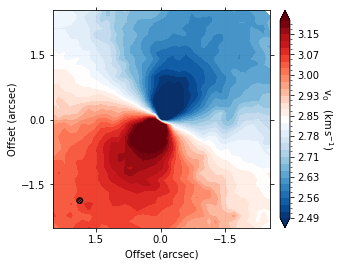

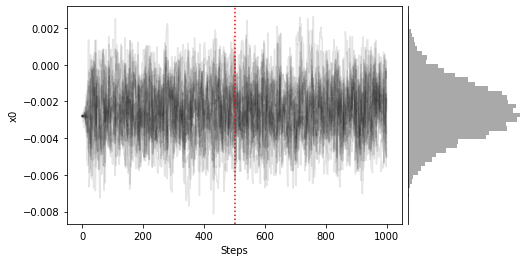

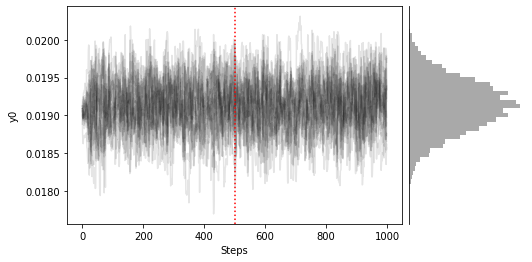

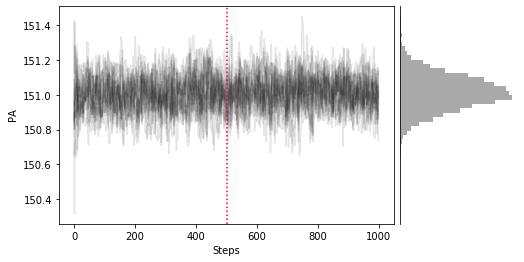

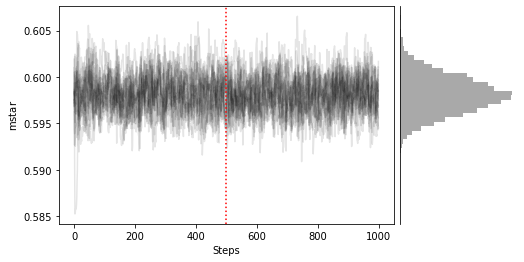

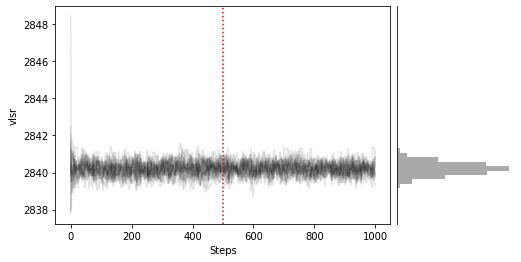

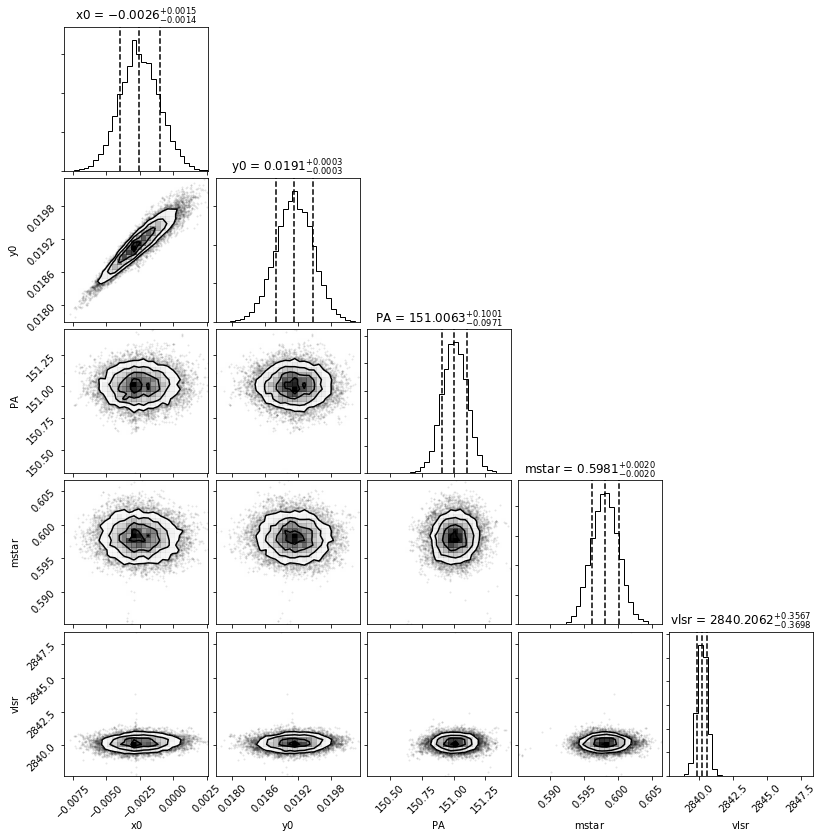

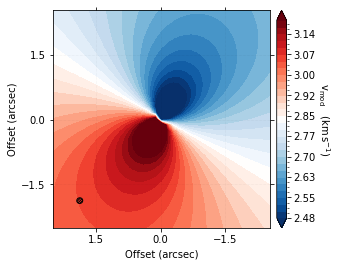

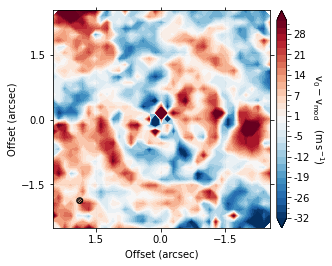

In [6]:
samples = cube.fit_map(p0=p0, params=params, nwalkers=16, nburnin=500, nsteps=500, returns='samples')

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['-2.80e-03', '1.91e-02', '1.51e+02', '5.98e-01', '2.84e+03']


100%|██████████| 1000/1000 [00:22<00:00, 44.10it/s]


(16, 1000, 5)


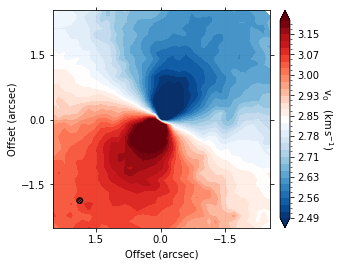

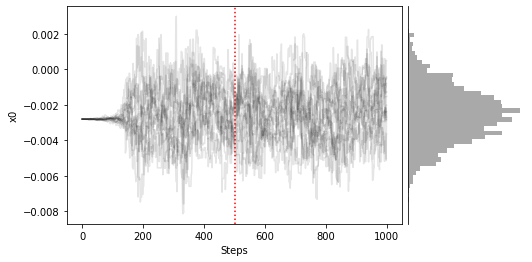

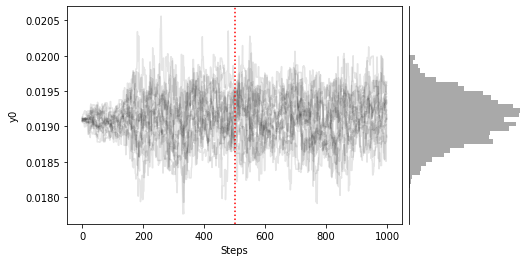

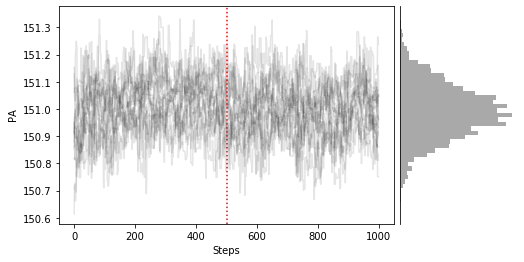

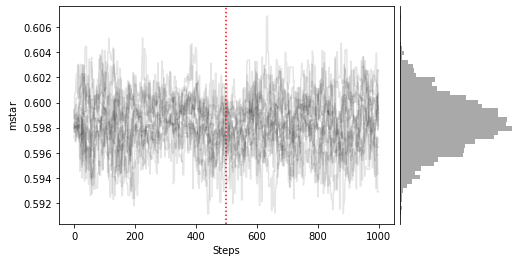

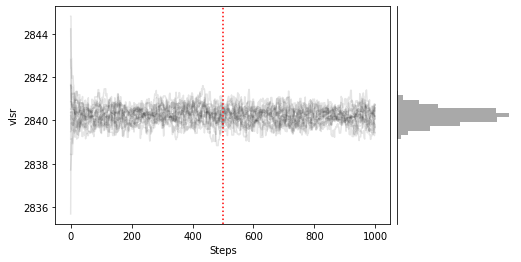

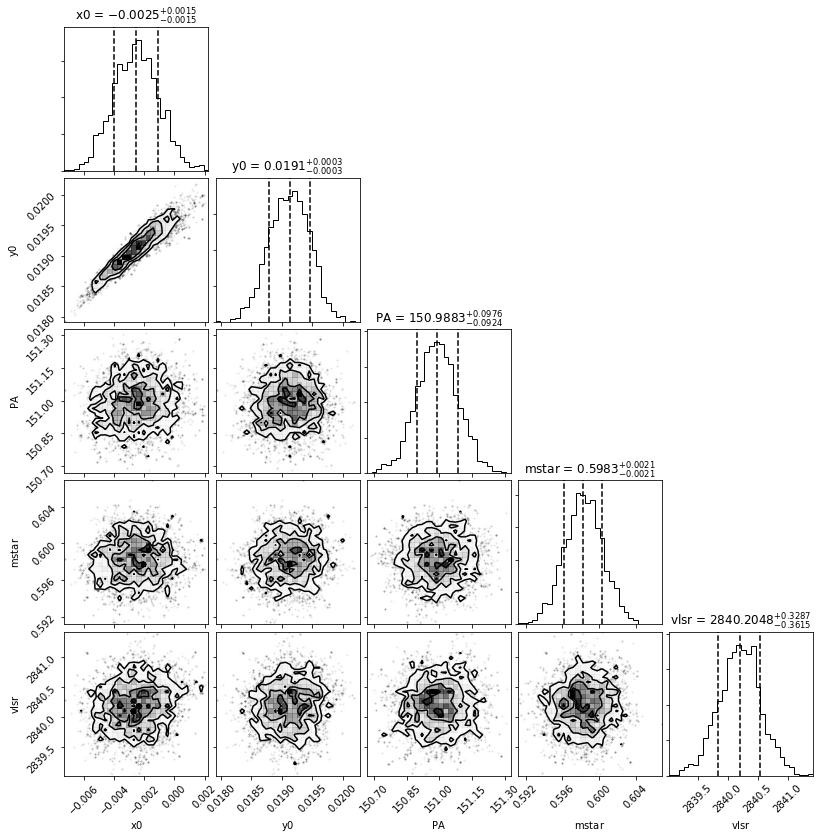

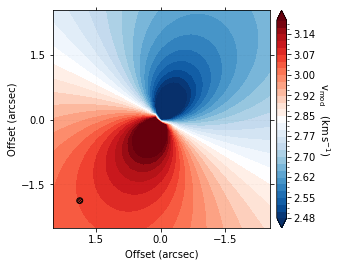

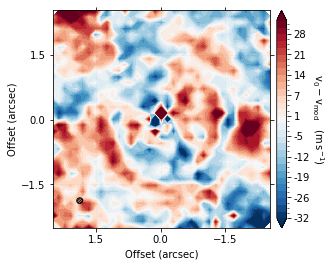

In [9]:
samples = cube.fit_map(p0=p0, params=params, nwalkers=16, nburnin=500, nsteps=500, returns='samples')

In [13]:
samples.shape

(8000, 5)

<a id='diagnostic_plots'></a>

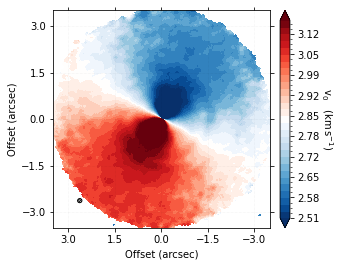

In [6]:
# Load up the data.

cube = rotationmap(path='../../cubes/TWHya_CO_cube_v0.fits',
                   uncertainty='../../cubes/TWHya_CO_cube_dv0.fits',
                   FOV=7.0)

# Inspect the data.

cube.plot_data()

In [16]:
x, y, z = cube.mirror_residual(samples, params, return_deprojected=False,
                               mirror_axis='major', deprojected_dpix_scale=4.0)

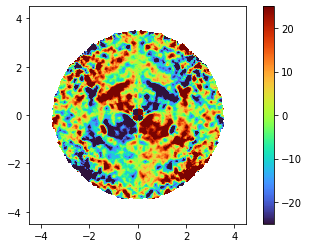

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(z, origin='lower', extent=[x[0], x[-1], y[0], y[-1]],
               vmin=-25, vmax=25, cmap='turbo')
plt.colorbar(im)

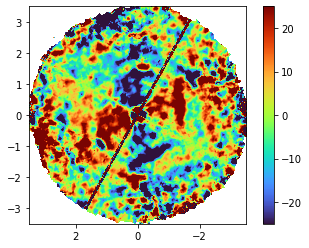

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(z, origin='lower', extent=[x[0], x[-1], y[0], y[-1]],
               vmin=-25, vmax=25, cmap='turbo')
plt.colorbar(im)

(-70.0, 70.0)

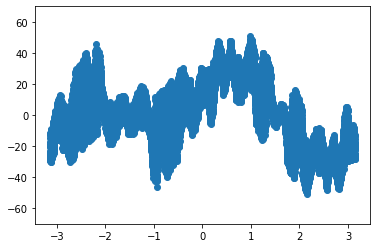

In [9]:
fig, ax = plt.subplots()

r = np.hypot(x[None, :], y[:, None]).flatten()
t = np.arctan2(y[:, None], x[None, :]).flatten()

mask = abs(r - 1.5) < 0.1

ax.scatter(t[mask], z.flatten()[mask])
ax.set_ylim(-70, 70)

In [10]:
from scipy.interpolate import griddata, interp2d, RectBivariateSpline

In [11]:
isinstance(int, params['x0'])

TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
# we need to do serveral things:

# 1 - build the best-fit model
# 2 - deproject the data using the best-fit geometrical parameters
# 3 - deproject the residual into a face-on inclination
# 4 - subtract the reflected data (should be along the y-axis if it is centered)
# 5 - reproject onto the sky (interp2d?)

model = cube.evaluate_models(samples, params)
rvals, tvals, zvals = cube.evaluate_models(samples, params, coords_only=True)
residual = cube.data * 1e3 - model
residual = cube.data * 1e3 - 2.84e3

tvals += np.pi / 2.0

axis = np.nanmax(np.where(np.isfinite(residual), rvals, np.nan))
axis = np.arange(-axis, axis, cube.dpix / 1.0)
axis -= (axis[0] + axis[-1]) / 2.0

gridded = griddata(((rvals * np.cos(tvals)).flatten(),
                    (rvals * np.sin(tvals)).flatten()),
                   residual.flatten(), (axis[:, None], axis[None, :]),
                   method='linear')
flipped = gridded + gridded[:, ::-1]


xgrid, ygrid = np.meshgrid(axis, axis)
xgrid, ygrid = xgrid.flatten(), ygrid.flatten()
zgrid = gridded.flatten()
mask = np.isfinite(zgrid)
xgrid, ygrid, zgrid = xgrid[mask], ygrid[mask], zgrid[mask]

f = interp2d(xgrid, ygrid, zgrid, kind='cubic')


onsky = np.squeeze([f(xx, yy) for xx, yy in zip((rvals * np.cos(tvals)).flatten(),
                    (rvals * np.sin(tvals)).flatten())]).reshape(residual.shape)
onsky = np.where(np.isfinite(residual), onsky, np.nan)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(residual, origin='lower', extent=cube.extent, cmap='turbo', vmin=-70, vmax=70)
plt.colorbar(im)

fig, ax = plt.subplots()
im = ax.imshow(gridded, origin='lower',
               extent=[axis[0], axis[-1], axis[0], axis[-1]], cmap='bwr',
               #vmin=-70, vmax=70,
              )
plt.colorbar(im)



fig, ax = plt.subplots()
im = ax.imshow(flipped, origin='lower',
               extent=[axis[0], axis[-1], axis[0], axis[-1]], cmap='bwr',
               vmin=-70, vmax=70,
              )
plt.colorbar(im)


fig, ax = plt.subplots()
im = ax.imshow(onsky,
               origin='lower', extent=cube.extent, cmap='bwr',
               #vmin=-70, vmax=70,
              )
plt.colorbar(im)




#### Diagnostic Plots

By default, `fit_map` will produce all the diagnostic plots. You can select which plots you want using the `plots` argument, which takes either a single (string) value, or a list of strings. The available options are:

* `'mask'` - Showing the masked regions of the data with a semi-transparent layover of the data.


* `'walkers'` - Shows the traces of the walkers for each parameter. In each panel, the dashed red line shows the end of the burn-in period. The histogram shows the collapsed posterior distribution for all samples taken after the burn-in period.


* `'corner'` - A typical corner (covariance) plot using [corner.py](https://github.com/dfm/corner.py) from Dan Foreman-Mackey. The labels will show the median value with uncertainties representing the 16th to 84th percentile rage.


* `'bestfit'` - A plot of the best-fit model (using the median value of the posteriors) with the mask overlaid.


* `'residual'` - A plot of the residuals between the data and the best fit model with the mask overlaid.


For example, if you wanted to just plot the residual you would use, `plots='residual'`, while for plots of the walkers and the corner plot you would use `plots=['walkers', 'corner']`. If you would like no plots, you can use `plots='none'` (careful to use a string here as `plots=None` is interpreted as the default of all plots).

In [ ]:
np.meshgrid?

<a id='returned_products'></a>

#### Returned Products

There are several different statistics or data products that can be returned after the MCMC, controlled with the `returns` argument. As for the plots, this takes either a single string or a list of strings. The available options are:

* `'samples'` - A `(nsteps, nparams)` shaped array of the posterior samples.


* `'percentiles'` - A `(3, nparams)` shaped array of the 16th, 50th and 84th percentiles of each parameter's posterior distribution.


* `'lnprob'` - A `nsteps` sized array of the log-probability for each posteroir sample.


* `'model'` - A 2D array of the best-fit model using the median value from the samples.


* `'residuals'` - A 2D array of the residuals after subtracting the best-fit model from the data.


* `'dict'` - A `params` dictionary where the free parameters have been replaced with the median values of the posterior distributions.


By default `eddy` will just return the percentiles of the fit. 

<a id='Evaluating Models'></a>

#### Evaluating Models


In the above it is assumed that the model parameters are independent such that taking the median of each posterior distribution provides the 'best-fit' model. Often parameteres are correlated and it is better to generate several realizations of the model from the posterior samples and then combine them. This can be achieved with the `evaluate_models` function.

Another advantage of the `evaluate_models` function is that if the fitting is performed on a downsampled array, reloading the data without any downsampling allows for the model to be calculated on the higher resolution grid.

First, we need to return the samples from the fit.

In [ ]:
samples = cube.fit_map(p0=p0, params=params, nwalkers=16, nburnin=200,
                       nsteps=100, plots='none', returns='samples')

By providing the dictionary and the samples, we can evaluate a number of models to average down. Here the `draws` argument tells the function how many random draws to take which are then averaged down to a single value. If `draws` is less than 1, this represents the percentile  of the posteriors to use (e.g., `draws=0.5` will use the median values from all posterior distributions).

In [ ]:
model = cube.evaluate_models(samples=samples, params=params, draws=100)

These can then be plotted with the `plot_model` convenience function.

In [ ]:
cube.plot_model(model / 1e3)  # convert from [m/s] to [km/s]

The `evaluate_models` function also allows for a user-defined function to collapse the multiple models, `collapse_func`. This is particularly useful if you want to see how much variability there is in the sample of models by looking at the standard deviation of the set.

In [ ]:
model = cube.evaluate_models(samples=samples, params=params, draws=100, collapse_func=np.std)

cube.plot_model(model, levels=np.linspace(0, 10, 200),
                contourf_kwargs=dict(cmap='inferno'),
                cb_label=r'$\delta v_0 \quad ({\rm m\,s^{-1}})$')

From this you can clearly see that there are only small variations between the models in the posterior samples.

### Masking Data

Oftentimes it is useful to only fit a specific region of your rotation map, perhaps because of large non-Keplerian features or cloud absorptions. In addition to just using `r_min` and `r_max` to specify the masked regions, you can use `PA_min` and `PA_max` to define minimum and maximum polar angles (_not_ position angle!) of the mask or `v_min` and `v_max` to define velocity ranges (most useful for masking out cloud contaminated regions which span a specific velocity range). For each of these parameters, there is also option to include or exclude that range, `exclude_r`, `exclude_PA` and `exclude_v`.

In [ ]:
params['r_min'] = 2.0 * cube.bmaj
params['r_max'] = 3.25

#### Parallelization

It's sometimes useful to parallelize the fitting. We can implement a naive approach using the `multiprocessing` package. We can provide a `pool` variable to `fit_map` which will interface with the MCMC. Note that this is implemented using the `with` statement so that it deals with the starting and closing of the pool.

__NOTE:__ It seems that currently the priors do not work correctly with parallelization. This is being investigated.

In [ ]:
from multiprocessing import Pool

with Pool() as pool:
    cube.fit_map(p0=p0, params=params, nwalkers=256, nburnin=200, nsteps=200, pool=pool)

You'll notice this is not vastly faster than the serial attempt because the whole class has to be pickled and read in and out, however we're able to run more walkers taking the same time. A more optimal parallel version is coming...